In this article, we explore the world of time series and how to implement the SARIMA model to forecast seasonal data using python. 

Why Natural Gas Storage Data?

The weekly natural gas storage data is a principal federal economic indicator used by the public to determine natural gas inventory levels, indicators of the balance between supply and demand in the natural gas market. According to the U.S. Energy Information Administration, upon release of the report, the natural gas market reacts to the derived net change in inventory levels from the prior week that often influences natural gas prices.

Importing Data and Libraries

Now, let's start creating the model by importing various libraries in Python that would make our job easier such as numpy, pandas, matplotlib, sklearn and statsmodels.

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
%matplotlib inline

Next, let's try to download the dataset used in this analysis from the U.S. EIA's website - Weekly Natural Gas Storage Report - EIA. In the output, you can see the last five elements of the datasheet i.e. tail of the dataset.

In [38]:
#Import data from EIA - Weekly Natural Gas Storage Report
data = pd.read_csv('NaturalGasStorageUS.csv')
data.tail()

,Week ending,East Region,Midwest Region,Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,Total Lower 48
575,08-Jan-21,726,879,188,278,1126,327,799,3196
576,15-Jan-21,679,828,176,275,1051,296,755,3009
577,22-Jan-21,641,780,170,275,1014,288,726,2881
578,29-Jan-21,582,719,158,261,970,281,689,2689
579,05-Feb-21,529,666,150,257,915,261,654,2518


Visualizing Dataset

Let's plot the graph between the week ending and the total lower 48 gas storage columns between 2010 and 2021. The code for producing this visualization is as follows:

<Figure size 864x360 with 0 Axes>

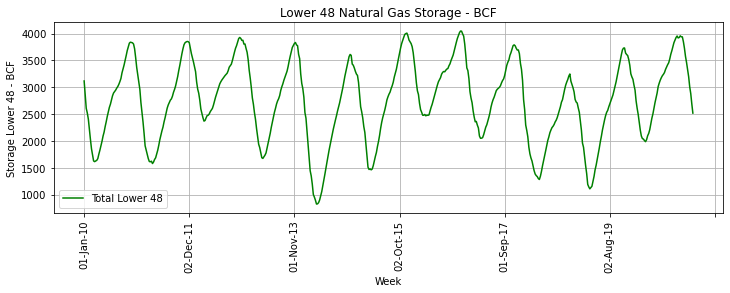

In [44]:
#Visualize the total natural gas storage data since 2010
plt.figure(figsize=[12, 5]); # Set dimensions for figure
data.plot(x='Week ending', y='Total Lower 48', figsize = (12, 3.5), legend = True, color='g')
plt.title('Lower 48 Natural Gas Storage - BCF')
plt.ylabel('Storage Lower 48 - BCF')
plt.xlabel('Week')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Testing the Stationarity of the Dataset

Let us utilize the Augmented Dickey-Fuller Test, a well known statistical test that can help determine if the time series is stationary. The ADF test is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if the unit root is present. The Null Hypothesis states there is the presence of a unit root. If the P-Value is less than the Significance Level defined, we reject the Null Hypothesis that the time series contains a unit root. In other words, by rejecting the Null hypothesis, we can conclude that the time series is stationary.

In [14]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['Total Lower 48'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.520456690936758
p-value: 1.8827985107022387e-06


In [15]:
best_model = SARIMAX(data['Total Lower 48'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 52)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Total Lower 48   No. Observations:                  580
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 52)   Log Likelihood               -2715.678
Date:                            Sun, 14 Feb 2021   AIC                           5445.356
Time:                                    09:27:48   BIC                           5475.226
Sample:                                         0   HQIC                          5457.050
                                            - 580                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0854      0.236      4.596      0.000       0.623       1.548
ar.L2         -0.2184      0.107   

After we have fitted the model to the data, we check the residual plots to verify the validity of the model fit. A good forecasting method will have minimal information left in the residuals if any.

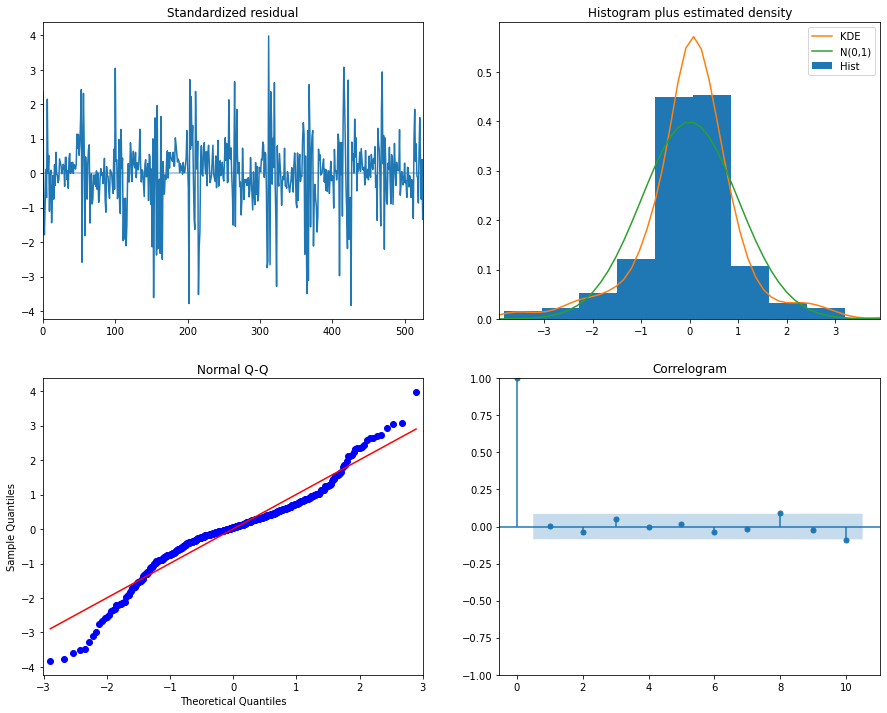

In [16]:
#Diagnosing the model residuals
best_model.plot_diagnostics(figsize=(15,12));

From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise. Therefore, these residuals are uncorrelated and have zero mean.

Model Forecast

In the forecast step, we will try to predict the Total Lower 48 natural gas storage data for the next 156 steps or 3 years. The graph below shows a remarkable fit to the historical storage data.

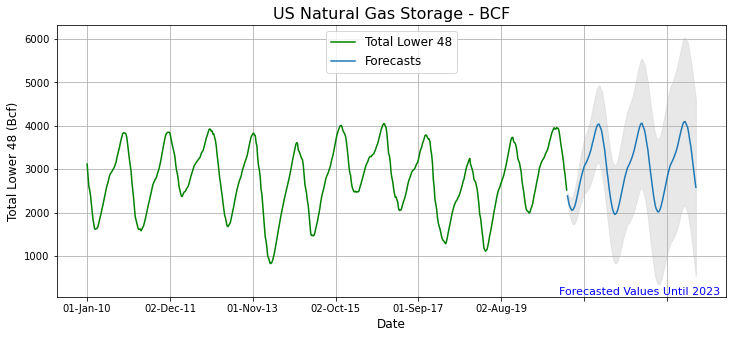

In [39]:
#Forecasting 3 years steps ahead
forecast_values = best_model.get_forecast(steps = 156)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = data.plot(x='Week ending', y='Total Lower 48', figsize = (12, 5), legend = True, color='g')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecasts', figsize = (12, 5), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='#D3D3D3', alpha = .5)
plt.title('US Natural Gas Storage - BCF', size = 16)
plt.ylabel('Total Lower 48 (Bcf)', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper center', prop={'size': 12})
#annotation
ax.text(570, 100, 'Forecasted Values Until 2023', fontsize=11,  color='blue')
plt.show()

In [48]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Total Lower 48'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Total Lower 48'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Total Lower 48'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['Total Lower 48'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Total Lower 48'])
                                                               /np.abs(test['Total Lower 48']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.997305,21.735051,917.57563,30.291511,0.727316
